# Plotting RBush

We want to see the structure of a RBush -- we want to plot the 2D spatial distribution of the items in a RBush tree.

We'll do that using [datashader][ds] and its companions, [xarray][xr], [bokeh][bk], [holoviews][hv], [pandas][pd], [numpy][np].

This exercise is based on:
* https://anaconda.org/jbednar/plotting_pitfalls/notebook
* https://anaconda.org/jbednar/pipeline/notebook

After a first approach, investigate/exercise the following:
* does bokeh-webgl engine support Rectangle glyph?


[ds]: http://datashader.readthedocs.io/
[xr]: http://xarray.pydata.org/
[bk]: https://bokeh.pydata.org
[hv]: http://holoviews.org/
[pd]: https://pandas.pydata.org/
[np]: http://www.numpy.org/

In [1]:
import datashader as ds
import xarray as xr
import bokeh as bk
import pandas as pd
import numpy as np
import numba as nb

from numba import njit
from datashader import transfer_functions as tf
from datashader import reductions
from datashader.colors import Hot, viridis

import rbush
from rbush.data import generate_data_array

In [2]:
print('datashader:',ds.__version__)
print('xarray:',xr.__version__)
print('bokeh:',bk.__version__)
print('pandas:',pd.__version__)
print('numpy:',np.__version__)
print('numba:',nb.__version__)

datashader: 0.6.4
xarray: 0.10.0
bokeh: 0.12.13
pandas: 0.20.3
numpy: 1.13.1
numba: 0.36.1


In [3]:
print('rbush-version:',rbush.__version__)

rbush-version: 0.0.2+22.gebee64d.dirty


## Build tree

In [4]:
import rbush

In [5]:
from rbush.data import generate_data_array

def gaussian_grid(N, INCREMENT, SIZE):
    arrays = []

    # bottom-left
    arr = generate_data_array(N, SIZE)
    arr += SIZE
    arrays.append(arr)

    # top-right
    arr = generate_data_array(N, SIZE)
    arr += INCREMENT - SIZE
    arrays.append(arr)

    # bottom-right
    arr = generate_data_array(N, SIZE)
    arr[:,0] += INCREMENT - SIZE
    arr[:,1] += SIZE
    arr[:,2] += INCREMENT - SIZE
    arr[:,3] += SIZE
    arrays.append(arr)

    # top-left
    arr = generate_data_array(N, SIZE)
    arr[:,0] += SIZE
    arr[:,1] += INCREMENT - SIZE
    arr[:,2] += SIZE
    arr[:,3] += INCREMENT - SIZE
    arrays.append(arr)

    # top-middle
    arr = generate_data_array(N, SIZE)
    arr[:,0] += INCREMENT // 2
    arr[:,1] += INCREMENT - SIZE
    arr[:,2] += INCREMENT // 2
    arr[:,3] += INCREMENT - SIZE
    arrays.append(arr)

    # bottom-middle
    arr = generate_data_array(N, SIZE)
    arr[:,0] += INCREMENT // 2
    arr[:,1] += SIZE
    arr[:,2] += INCREMENT // 2
    arr[:,3] += SIZE
    arrays.append(arr)

    # left-middle
    arr = generate_data_array(N, SIZE)
    arr[:,0] += SIZE
    arr[:,1] += INCREMENT // 2
    arr[:,2] += SIZE
    arr[:,3] += INCREMENT // 2
    arrays.append(arr)

    data = np.concatenate(arrays, axis=0)
    return data

N = int(1e5)
EXTENT = 1000
SIZE = 100
data = gaussian_grid(N, EXTENT, SIZE)
print('Length: {:,}'.format(len(data)))
data

Length: 700,000


array([[ 253.25462102,   30.72077097,  201.41277847,  -36.42829072],
       [ -10.24750166,  290.27692419,  -21.59589286,  313.58017754],
       [  57.6716572 ,  199.58834371,  141.7014724 ,  -30.28044405],
       ..., 
       [  61.33084724,  424.14115997,  -16.11407163,  292.30947437],
       [  49.66874695,  542.51941323,  -78.70590948,  372.72746889],
       [ -28.40403997,  385.28721544,  -86.79793014,  417.9914486 ]])

In [6]:
t = rbush.RBush()
%time t.load(data)

CPU times: user 8.31 s, sys: 237 ms, total: 8.55 s
Wall time: 9.13 s


In [7]:
bboxes, ndata = t.all()
bboxes.shape

(700000, 4)

In [8]:
# Apart from (raw) permutations, 'data' and 'bboxes' should contain the same information
assert data.shape==bboxes.shape

In [9]:
ad = np.asarray([data.min(axis=0),data.max(axis=0),data.mean(axis=0)], int)
print(ad)

[[-339 -358 -530 -595]
 [1356 1410 1540 1486]
 [ 442  500  443  500]]


In [10]:
ab = np.asarray([bboxes.min(axis=0),bboxes.max(axis=0),bboxes.mean(axis=0)], int)
print(ab)

[[-339 -358 -530 -595]
 [1356 1410 1540 1486]
 [ 442  500  443  500]]


In [11]:
assert np.array_equal(ad,ab)

In [12]:
del data, ad, ab

## Visualizing Rbush' nodes with datashader

Datashader works in a canvas represented by an `xarray` where each element is a bin.
The bin represents a pixel in a (data) coordinates system.
Each bin contains information aggregated from the dataset(s) at that (pixel) position.

Let's say we want to count the number of items (bounding-boxes in our dataset) that cover each position in the dataset parameters space (xmin,ymin,xmax,ymax) -- i.e, we want a heatmap of the items (space) distribution.

Each bin in the datashader (xarray) canvas will contain the number of items covering that area.

As a first approach, let's do the representation of items' centroids.
Then we evolve to plotting the boxes' coverage area.

### Plot: centroids

In [13]:
df = pd.DataFrame(bboxes, columns=['xmin','ymin','xmax','ymax'])
df['x'] = df[['xmin','xmax']].mean(axis=1)
df['y'] = df[['ymin','ymax']].mean(axis=1)
df.describe()

xmin           ymin           xmax           ymax  \
count  700000.000000  700000.000000  700000.000000  700000.000000   
mean      442.891961     500.162349     443.004960     500.160415   
std       347.857516     383.519748     362.077968     396.272856   
min      -339.884952    -358.303588    -530.525939    -595.961337   
25%       121.114601     121.123459     128.440667     129.416735   
50%       432.888026     500.391211     413.505264     500.579837   
75%       786.046717     879.168729     758.989730     870.842929   
max      1356.959478    1410.157084    1540.491610    1486.061515   

                   x              y  
count  700000.000000  700000.000000  
mean      442.948460     500.161382  
std       351.500364     386.730132  
min      -402.876383    -438.720484  
25%       123.370598     123.514163  
50%       425.935333     500.449352  
75%       775.140422     876.763734  
max      1415.268669    1402.834354

In [14]:
# Data limits/range. We'll  use to define our canvas data space
#
BORDER = 100
x_lims = [int(df.xmin.min()) - BORDER, int(df.xmax.max()+1) + BORDER]
y_lims = [int(df.ymin.min()) - BORDER, int(df.ymax.max()+1) + BORDER]
print("Data limits:\n x: {}, y: {}\n".format(x_lims,y_lims))

Data limits:
 x: [-439, 1641], y: [-458, 1587]



<xarray.DataArray (y: 400, x: 800)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)
Coordinates:
  * y        (y) float64 -455.4 -450.3 -445.2 -440.1 -435.0 -429.9 -424.8 ...
  * x        (x) float64 -437.7 -435.1 -432.5 -429.9 -427.3 -424.7 -422.1 ...


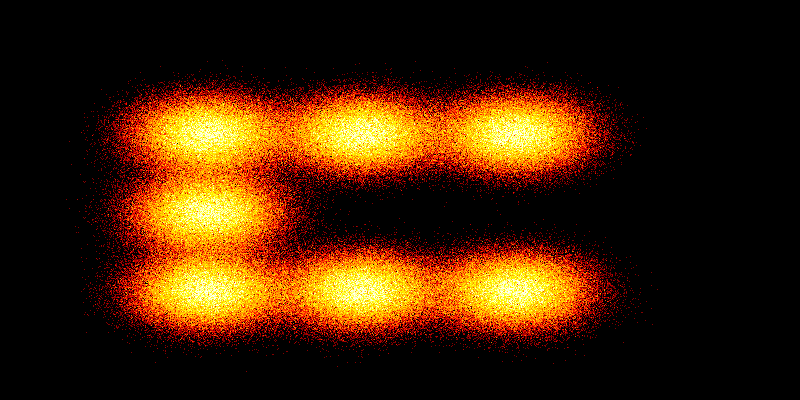

In [15]:
from datashader import transfer_functions as tf
from datashader import reductions
from datashader.colors import Hot, viridis

# We will represent centroids
glyph = ds.glyphs.Point('x', 'y')

# 400 x 800 pixels
canvas = ds.Canvas(plot_width=800, plot_height=400, x_range=x_lims, y_range=y_lims)

agg = canvas.points(df,'x','y', agg=reductions.count())
print(agg)

img = tf.shade(agg, cmap=Hot, how='eq_hist')
tf.set_background(img, 'black')

### Plot: bounding-boxes

To plot the items coverage we have to rasterize the bounding-boxes defined by our rbush items.
Size and quality of the image are dictated by the image's size and resolution; we have to choose one and other will adapt to fit data' limits.

We here, first, choose for fixing the resolution.

In [16]:
# Say we want to see in a resolution of "1 data-unit" of the (variable) data axes range
x_res = 1.0
y_res = 1.0
print("Canvas resolution(in 'data' units):\n x: {}, y: {}\n".format(x_res,y_res))

x_size = int((x_lims[1] - x_lims[0])/x_res)
y_size = int((y_lims[1] - y_lims[0])/y_res)
print("Canvas' axes size:\n x: {}, y: {}\n".format(x_size,y_size))

Canvas resolution(in 'data' units):
 x: 1.0, y: 1.0

Canvas' axes size:
 x: 2080, y: 2045



In [17]:
# Define the functions to transform coordinates 'data'<->'canvas'

def def_pos2pix(pmin,res):
    pos_zero = int(pmin/res)
    def f(pos):
        return int(pos/res) - pos_zero
    return f


def def_pix2pos(pmin,res):
    def f(pix):
        return pix*res + pmin
    return f

pos2pix_x = def_pos2pix(x_lims[0], x_res)
pos2pix_y = def_pos2pix(y_lims[0], y_res)

pix2pos_x = def_pix2pos(x_lims[0], x_res)
pix2pos_y = def_pix2pos(y_lims[0], y_res)

In [18]:
# Rasterize data
def pos2pix_data(a, data):
    for i in range(len(data)):
        row = data[i]
        xi = pos2pix_x(row[0])
        yi = pos2pix_y(row[1])
        xf = pos2pix_x(row[2])
        yf = pos2pix_y(row[3])
        a[yi:yf,xi:xf] += 1

# Array to represent the heatmap/histogram
a = np.zeros((y_size,x_size),dtype=int)

%time pos2pix_data(a, bboxes)

CPU times: user 8.6 s, sys: 35.1 ms, total: 8.63 s
Wall time: 8.65 s


In [19]:
# Let's build an xarray from 'a', which will effectively become our canvas (plot)

xaxis = np.arange(x_lims[0], x_lims[1], x_res)
yaxis = np.arange(y_lims[0], y_lims[1], y_res)
axx = xr.DataArray(a, dims=['y','x'], coords={'x':xaxis, 'y':yaxis})
axx

<xarray.DataArray (y: 2045, x: 2080)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x        (x) float64 -439.0 -438.0 -437.0 -436.0 -435.0 -434.0 -433.0 ...
  * y        (y) float64 -458.0 -457.0 -456.0 -455.0 -454.0 -453.0 -452.0 ...

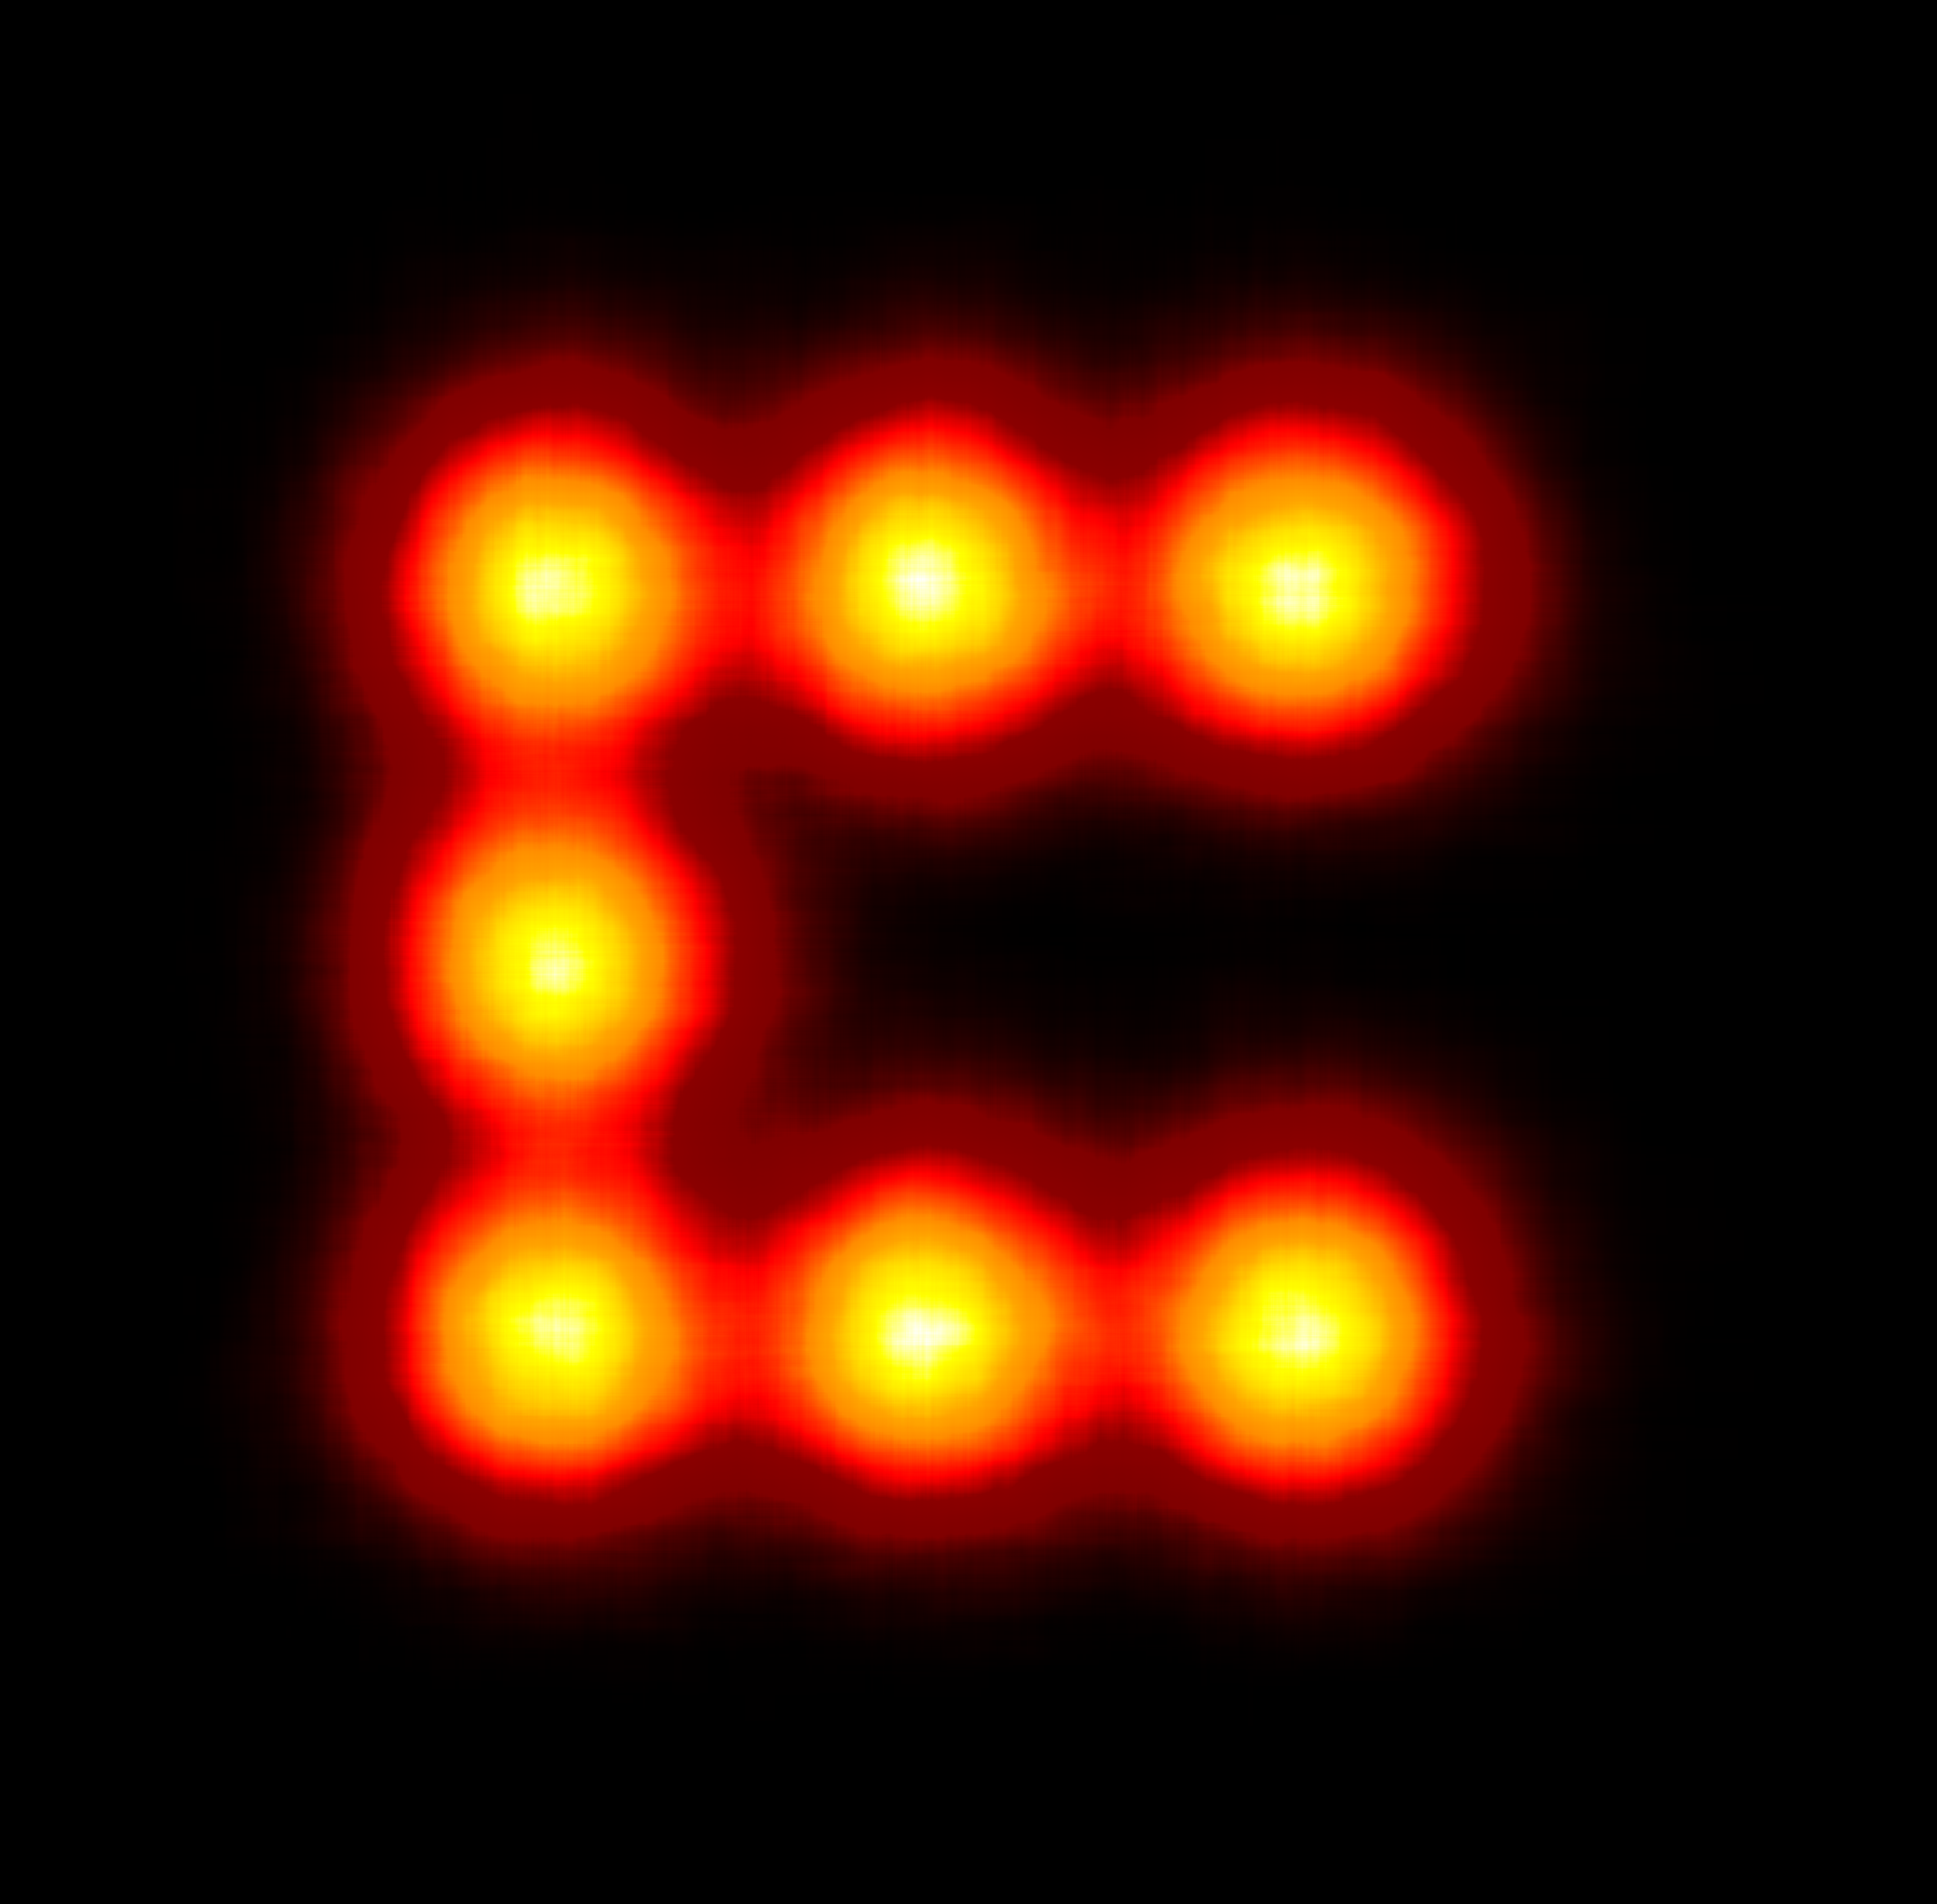

In [20]:
from datashader import transfer_functions as tf
from datashader import reductions
from datashader.colors import Hot

img = tf.shade(axx, cmap=Hot, how='linear')
tf.set_background(img, 'black')

#### Define canvas size first, resolution follows

In [21]:
x_size = 400
y_size = 300
print("Canvas' axes size:\n x: {}, y: {}\n".format(x_size,y_size))

# Say we want to see in a resolution of "1 data-unit" of the (variable) data axes range
x_res = (x_lims[1] - x_lims[0])/x_size
y_res = (y_lims[1] - y_lims[0])/y_size
print("Canvas resolution(in 'data' units):\n x: {}, y: {}\n".format(x_res,y_res))

Canvas' axes size:
 x: 400, y: 300

Canvas resolution(in 'data' units):
 x: 5.2, y: 6.816666666666666



In [22]:
pos2pix_x = def_pos2pix(x_lims[0], x_res)
pos2pix_y = def_pos2pix(y_lims[0], y_res)

pix2pos_x = def_pix2pos(x_lims[0], x_res)
pix2pos_y = def_pix2pos(y_lims[0], y_res)

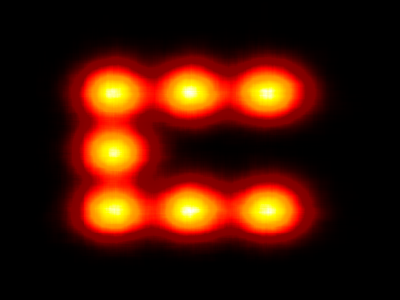

In [23]:
a = np.zeros((y_size,x_size),dtype=int)
pos2pix_data(a, bboxes)

xaxis = np.linspace(x_lims[0], x_lims[1], x_size)
yaxis = np.linspace(y_lims[0], y_lims[1], y_size)

axx = xr.DataArray(a, dims=['y','x'], coords={'x':xaxis, 'y':yaxis})

img = tf.shade(axx, cmap=Hot, how='linear')
tf.set_background(img, 'black')

# Numba version

Now we're going to define the functions we used before using numba

In [24]:
xsize = 600
ysize = 400

xlims = x_lims
ylims = y_lims

xres = (xlims[1]-xlims[0])/xsize
yres = (ylims[1]-ylims[0])/ysize

In [25]:
from numba import guvectorize, vectorize
from numba import int64,float64,void

@vectorize(["int64(float64, float64, float64)"])
def pos2pix(pos, min_pos, res):
    return int64((pos - min_pos)/res)

@guvectorize(["void(float64[:,:], float64[:], float64[:], int64[:,:])"], "(n,c),(c),(c)->(n,c)")
def pos2pix_data(arr_data, posv, resv, pix):
    for i in range(arr_data.shape[0]):
        pix[i,:] = pos2pix(arr_data[i,:], posv, resv)

@njit('void(int64[:,:],int64[:,:])')
def rasterize(arr_pix, arr_canvas):
    for i in range(arr_pix.shape[0]):
        row = arr_pix[i]
        xi = row[0]
        yi = row[1]
        xf = row[2]
        yf = row[3]
        for y in range(yi,yf):
            for x in range(xi,xf):
                arr_canvas[y,x] += 1



a = np.zeros((ysize,xsize),dtype=int)

xmin = float(xlims[0])
ymin = float(ylims[0])
posv = np.array([xmin, ymin, xmin, ymin], dtype=float)
resv = np.array([xres, yres, xres, yres], dtype=float)

pix = np.zeros(bboxes.shape, dtype=int)

%time pos2pix_data(bboxes, posv, resv, pix)
%time rasterize(pix,a)

CPU times: user 99.1 ms, sys: 473 µs, total: 99.5 ms
Wall time: 100 ms
CPU times: user 90 ms, sys: 1.58 ms, total: 91.6 ms
Wall time: 91.8 ms


In [26]:
# Let's build an xarray from 'a'
# xarray have a coordinates attribute ('coords'), apart from dimensions ('dims')

xaxis = np.arange(xlims[0], xlims[1], xres)
yaxis = np.arange(ylims[0], ylims[1], yres)
axx = xr.DataArray(a, dims=['y','x'], coords={'x':xaxis, 'y':yaxis})
axx

<xarray.DataArray (y: 400, x: 600)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x        (x) float64 -439.0 -435.5 -432.1 -428.6 -425.1 -421.7 -418.2 ...
  * y        (y) float64 -458.0 -452.9 -447.8 -442.7 -437.5 -432.4 -427.3 ...

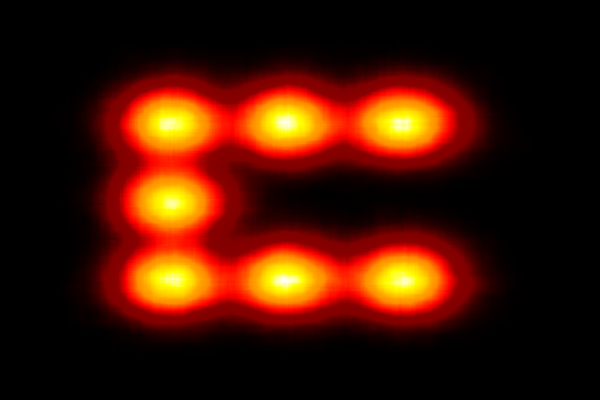

In [27]:
from datashader import transfer_functions as tf
from datashader import reductions
from datashader.colors import Hot

img = tf.shade(axx, cmap=Hot, how='linear')
tf.set_background(img, 'black')

## Interactive view

In [28]:
from bokeh.plotting import figure
from bokeh.io import output_notebook
output_notebook()

x_range = xlims
y_range = ylims

plot_width  = int(750)
plot_height = int(plot_width//1.2)

def base_plot(tools='pan,box_zoom,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
    
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p
    
# options = dict(line_color=None, fill_color='blue', size=5)

Loading BokehJS ...

In [29]:
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from IPython.core.display import HTML, display

background = "black"
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))

def create_image(x_range, y_range, w=plot_width, h=plot_height):

    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    
    agg = cvs.points(df, 'x', 'y', agg=reductions.count())
    
    img = tf.shade(agg, cmap=Hot, how='eq_hist')
    return tf.dynspread(img, threshold=0.5, max_px=4)

p = base_plot(background_fill_color=background)
export(create_image(x_range, y_range),"RBush")

InteractiveImage(p, create_image)


In [30]:
print(x_range,y_range)

[-439, 1641] [-458, 1587]


In [31]:
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from IPython.core.display import HTML, display

background = "black"
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))

def query_tree(x_range, y_range):    
    bboxes,_ = t.search(x_range[0], y_range[0], x_range[1], y_range[1])
    
    df = pd.DataFrame(bboxes, columns=['xmin','ymin','xmax','ymax'])
    df['x'] = df[['xmin','xmax']].mean(axis=1)
    df['y'] = df[['ymin','ymax']].mean(axis=1)
    return df

def create_image(x_range, y_range, w=plot_width, h=plot_height):
    
    # query rbush for only rectangles inside of ranges
    df = query_tree(x_range, y_range)
    
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    
    agg = cvs.points(df, 'x', 'y', agg=reductions.count())
    
    img = tf.shade(agg, cmap=Hot, how='eq_hist')
    return tf.dynspread(img, threshold=0.5, max_px=4)

p = base_plot(background_fill_color=background)
export(create_image(x_range, y_range),"RBush")

InteractiveImage(p, create_image)


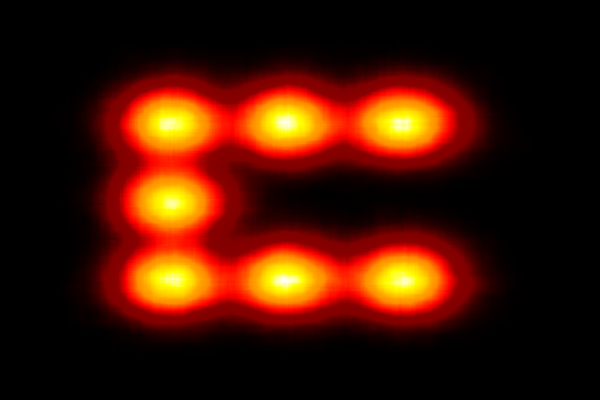

In [32]:
def set_canvas(x_range, y_range, rbush_tree):
#     print(x_range, y_range)
    
    xres = (x_range[1] - x_range[0])/xsize
    yres = (y_range[1] - y_range[0])/ysize
    
    a = np.zeros((ysize,xsize),dtype=int)

    xmin = float(x_range[0])
    ymin = float(y_range[0])
    posv = np.array([xmin, ymin, xmin, ymin], dtype=float)
    resv = np.array([xres, yres, xres, yres], dtype=float)

    bboxes,_ = rbush_tree.search(x_range[0], y_range[0], x_range[1], y_range[1])

    pix = np.zeros(bboxes.shape, dtype=int)

    pos2pix_data(bboxes, posv, resv, pix)

    rasterize(pix,a)

    xaxis = np.arange(x_range[0], x_range[1], xres)
    yaxis = np.arange(y_range[0], y_range[1], yres)
    axx = xr.DataArray(a, dims=['y','x'], coords={'x':xaxis, 'y':yaxis})
    return axx


xax = set_canvas(x_range, y_range, t)

img = tf.shade(xax, cmap=Hot, how='linear')
tf.set_background(img, 'black')


In [33]:
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from IPython.core.display import HTML, display

background = "black"
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))

def create_image(x_range, y_range, w=plot_width, h=plot_height):
    # query rbush for only rectangles inside of ranges
    xax = set_canvas(x_range, y_range, t)

    img = tf.shade(xax, cmap=Hot, how='linear')

    return tf.dynspread(img, threshold=0.5, max_px=4)

p = base_plot(background_fill_color=background)
export(create_image(x_range, y_range),"RBush")

InteractiveImage(p, create_image, timeout=20)


**When we zoom-in we see there is a bug: the image presents a mirror effect.** After reviewing the code -- and the error not been found -- I am in doubt about how to debug that. May be an effect of the slowness of Rbush' query?: datashader would get confused when timeout is exceeded. (although a timeout sufficiently large doesn't solve the issue)